In [ ]:
!pip install rdkit-pypi
!pip install git+https://github.com/samoturk/mol2vec

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn import manifold, datasets
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

from rdkit import Chem
from gensim.models import word2vec
#from mol2vec import features
from mol2vec import helpers
from mol2vec.features import mol2alt_sentence, mol2sentence,MolSentence,DfVec,sentences2vec


from google.colab import drive
drive.mount('/content/gdrive')

import os 
os.chdir('/content/gdrive/MyDrive/Project')

# Load datasets
pKa=pd.read_csv('pKa.csv').iloc[:,:2]
hfus=pd.read_csv('hfus.csv').iloc[:,:2]

Y_pKa=pd.read_csv('pKa.csv').iloc[:,1]
Y_hfus=pd.read_csv('hfus.csv').iloc[:,1]

x_pKa=pd.read_csv('pKa.csv').iloc[:,0]
x_hfus=pd.read_csv('hfus.csv').iloc[:,0]

pKa.columns=['smiles','target']
hfus.columns=['smiles','target']
pKa=pKa.astype(object)
hfus=hfus.astype(object)

pKa.head()
hfus.head()

pKa['mol']=pKa['smiles'].apply(lambda x_pKa: Chem.MolFromSmiles(x_pKa))
hfus['mol']=hfus['smiles'].apply(lambda x_hfus: Chem.MolFromSmiles(x_hfus))

model=word2vec.Word2Vec.load('model_300dim.pkl')
pKa['sentence']= None
hfus['sentence']= None

for i in range(pKa.shape[0]):
  try:
    m1=pKa['mol'][i]
    pKa.loc[i,'sentence']=MolSentence(mol2alt_sentence(m1,1))
  except:
    #pKa.loc[i,'sentence']=MolSentence(mol2alt_sentence(m1,1))
    print('skipped:{}'.format(pKa['smiles'][i]))
pKa.dropna(inplace=True)
pKa.head()

pKa['mol2vec']=[DfVec(x) for x in sentences2vec(pKa['sentence'],model,unseen='UNK')]
X_pka=np.array([x.vec for x in pKa['mol2vec']])
y_pka=pKa['target'].values.astype(np.float32)


for i in range(hfus.shape[0]):
  try:
    m2=hfus['mol'][i]
    hfus.loc[i,'sentence']=MolSentence(mol2alt_sentence(m2,1))
  except:
    #hfus.loc[i,'sentence']=MolSentence(mol2alt_sentence(m2,1))
    print('skipped:{}'.format(hfus['smiles'][i]))
hfus.dropna(inplace=True)
hfus.head()

hfus['mol2vec']=[DfVec(x) for x in sentences2vec(hfus['sentence'],model,unseen='UNK')]
X_hfus=np.array([x.vec for x in hfus['mol2vec']])
y_hfus=hfus['target'].values.astype(np.float32)

hfus_df = pd.DataFrame(X_hfus)
hfus_df['hfus'] =  hfus['mol2vec']

pka_df = pd.DataFrame(X_pka)
pka_df['pka'] = pKa['mol2vec']


  Cloning https://github.com/samoturk/mol2vec to /tmp/pip-req-build-rmabs_vp
  Running command git clone -q https://github.com/samoturk/mol2vec /tmp/pip-req-build-rmabs_vp
Mounted at /content/gdrive
skipped:O=c1nnnc2ccccc12
skipped:O=c1c2ccccc2cc3ccccc13


In [ ]:


hfus_df['target']= y_hfus
pka_df['target']= y_pka

In [ ]:
print(pka_df)
print(hfus_df)


             0          1  ...                        pka  target
0     0.630492  -0.828383  ...  (300,) dimensional vector   15.50
1     1.038911  -0.149175  ...  (300,) dimensional vector    3.95
2     0.309878  -0.362497  ...  (300,) dimensional vector    5.20
3    -1.436814   0.340776  ...  (300,) dimensional vector    7.68
4     2.746283  -1.525258  ...  (300,) dimensional vector    5.04
...        ...        ...  ...                        ...     ...
1627  0.868221   0.083541  ...  (300,) dimensional vector    0.51
1628 -0.883809  -0.682177  ...  (300,) dimensional vector   10.91
1629  1.547302 -16.524574  ...  (300,) dimensional vector    8.36
1630  3.374413  -0.748670  ...  (300,) dimensional vector    4.98
1631 -0.693488   0.898655  ...  (300,) dimensional vector    9.12

[1632 rows x 302 columns]
            0         1  ...                       hfus     target
0   -1.619512 -0.161888  ...  (300,) dimensional vector  10.800000
1   -0.686014 -0.228154  ...  (300,) dimensiona

In [ ]:
# tSNE definition 

def tsneresult (dataset, perplexity):
  tsne = TSNE(n_components = 2, perplexity = perplexity, learning_rate = 'auto', init = 'random') 
  tsne_result = tsne.fit_transform(dataset)
  print(tsne_result.shape)
  return tsne_result

def tsneresult_3d (dataset, perplexity):
  tsne = TSNE(n_components = 3, perplexity = perplexity, learning_rate = 'auto', init = 'random') 
  tsne_result = tsne.fit_transform(dataset)
  print(tsne_result.shape)
  return tsne_result


def tsnegraph (dataset, tsne_result, perplexity, prop):
  dataset['tsne_D1'] = tsne_result[:, 0]
  dataset['tsne_D2'] = tsne_result[:, 1]
  plt.figure(figsize = (8, 5)) #16, 10
  sns.scatterplot(x = 'tsne_D1', y = 'tsne_D2', hue = prop, palette = sns.color_palette("coolwarm", as_cmap=True), data = dataset, alpha = 0.3)
  plt.title('perplexity = {}'.format(perplexity))

def tsnegraph_3d (dataset, tsne_result, perplexity, prop):
  dataset['tsne_D1'] = tsne_result[:, 0]
  dataset['tsne_D2'] = tsne_result[:, 1]
  dataset['tsne_D3'] = tsne_result[:, 2]
  plot = px.scatter_3d(x='tsne_D1',y='tsne_D2',z='tsne_D3',data_frame = dataset, color = prop, opacity=0.5, title = prop)
  plot.show()

In [ ]:
#2D tSNE 
hfus_result = tsneresult(X_hfus, 100)
pka_result = tsneresult(X_pka, 100)

(748, 2)
(1632, 2)


In [ ]:
# Generate 3D parameters using tSNE
hfus_3d_result = tsneresult_3d(X_hfus, 100)
pka_3d_result = tsneresult_3d(X_pka, 100)

(748, 3)
(1632, 3)


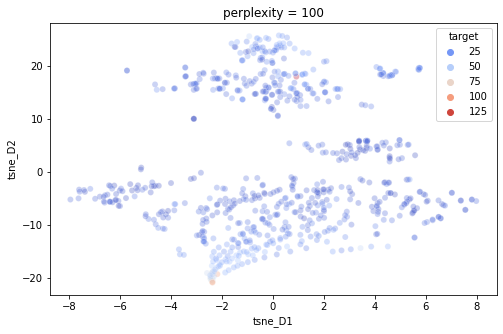

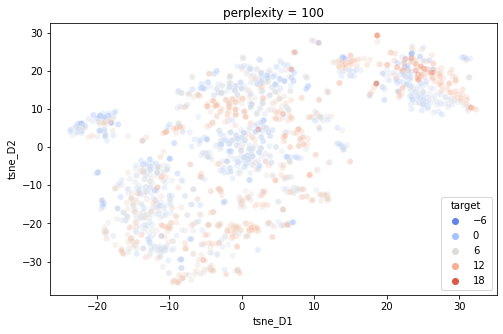

In [ ]:
#2D Visualization on mol2vec results
tsnegraph(hfus_df, hfus_result, 100, prop = 'target') 
tsnegraph(pka_df, pka_result, 100, prop = 'target')

In [ ]:
# 3D Visualization
tsnegraph_3d(hfus_df, hfus_3d_result, 100, prop = 'target')
tsnegraph_3d(pka_df, pka_3d_result, 100, prop = 'target')